# Load results

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

outpath  = 'resources/L5cell/'
cell_id = 0

### Check membrane voltage

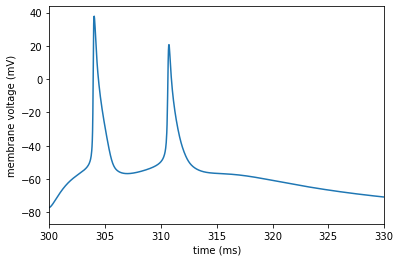

In [2]:
filename = 'v_report.h5'
v_file = outpath + filename
with h5py.File(v_file,'r') as v_f:
    idx = v_f['report/biophysical/mapping/node_ids'][()].tolist().index(cell_id)
    idx = slice(*v_f['report/biophysical/mapping/index_pointer'][()][[idx, idx+1]])
    V = v_f['report/biophysical/data'][()][:,idx]
    t = np.arange(*v_f['report/biophysical/mapping/time']) # array of time
    seg_x = v_f['report/biophysical/mapping/element_pos'][()]
    sec_id = v_f['report/biophysical/mapping/element_ids'][()]

idx = (sec_id==0) & (seg_x==0.5)
plt.figure()
plt.plot(t, V[:, idx])
plt.xlabel('time (ms)')
plt.ylabel('membrane voltage (mV)')
plt.xlim([300,330])
plt.show()

### Check transmembran current

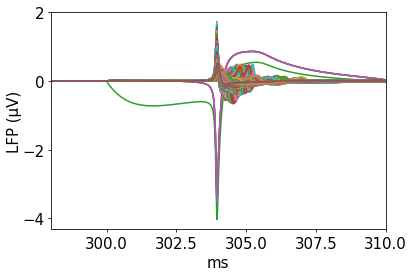

In [3]:
from utils.plotting.plot_results import plot_lfp_traces

filename = 'trans_mem_report.h5'
im_file = outpath  + filename
with h5py.File(im_file,'r') as im_f:
    dt = im_f['report/biophysical/mapping/time'][2]
    idx = im_f['report/biophysical/mapping/node_ids'][()].tolist().index(cell_id)
    idx = slice(*im_f['report/biophysical/mapping/index_pointer'][()][[idx, idx+1]])
    im = im_f['report/biophysical/data'][()][:,idx].T
    seg_x = im_f['report/biophysical/mapping/element_pos'][()]
    sec_id = im_f['report/biophysical/mapping/element_ids'][()]

idx = (t>=298) & (t<=310.)
fig,ax = plot_lfp_traces(t[idx],im.T[idx, :],fontsize=15,labelpad=0,ticksize=15,tick_length=3,nbins=5)

im = im[:, idx]
t = t[:im.shape[1]]

### Get segment properties

In [4]:
filename = 'seg_coords_dict.npy'
seg_coord_file = outpath  + filename
seg_coords_bmtk = np.load(seg_coord_file, allow_pickle=True).item()

seg_coords = {}
seg_coords['dl'] = (seg_coords_bmtk['p1']-seg_coords_bmtk['p0']).T
seg_coords['pc'] = seg_coords_bmtk['p05'].T
seg_coords['r'] = np.fmax(seg_coords_bmtk['d0'], seg_coords_bmtk['d1'])/2

filename = 'Segments.csv'
seg_prop_file = outpath  + filename
df_seg = pd.read_csv(seg_prop_file)
df_seg.sort_values(['BMTK ID', 'X'], inplace=True, ignore_index=True)
display(df_seg)

,BMTK ID,X,Type,Sec ID,Distance,Section_L,Section_diam,Coord X,Coord Y,Coord Z,Elec_distance,Elec_distance_nexus,HVA_gbar
0,0,0.100000,soma,0,2.316936,23.169362,17.526643,-9.249733,-0.577674,0.0,0.999038,0.198622,0.0
1,0,0.300000,soma,0,6.950809,23.169362,17.526643,-4.624868,-0.288877,0.0,0.999639,0.198907,0.0
2,0,0.500000,soma,0,11.584681,23.169362,17.526643,-0.000010,0.000021,0.0,1.000000,0.199079,0.0
3,0,0.700000,soma,0,16.218553,23.169362,17.526643,4.624854,0.288824,0.0,0.999646,0.198911,0.0
4,0,0.900000,soma,0,20.852426,23.169362,17.526643,9.249712,0.577722,0.0,0.999024,0.198616,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2521,195,0.357143,axon,1,52.298967,30.000000,1.000000,13.486402,38.415725,0.0,0.523874,0.045773,0.0
2522,195,0.500000,axon,1,56.584681,30.000000,1.000000,14.906023,42.459489,0.0,0.498795,0.042068,0.0
2523,195,0.642857,axon,1,60.870395,30.000000,1.000000,16.325643,46.503252,0.0,0.475990,0.038910,0.0
2524,195,0.785714,axon,1,65.156110,30.000000,1.000000,17.745267,50.547015,0.0,0.455165,0.036185,0.0


In [5]:
seg_prop = {}
# list of swc type id of sections
swc_type_id = {'soma': 1, 'axon': 2, 'dend': 3, 'apic': 4}
seg_prop['swc_type'] = np.array([swc_type_id[x] for x in df_seg['Type'].values])
# sections and segments id's
sec_id = df_seg['BMTK ID'].values
nseg = []
for iseg in sec_id:
    if iseg >= len(nseg):
        nseg.append(1)
    else:
        nseg[-1] += 1
sec_id_in_seg = np.cumsum([0] + nseg[:-1])
# segment length, area and distance
seg_length = [L / nseg[sec_id[i]] for i, L in df_seg['Section_L'].iteritems()]
seg_prop['seg_area'] = np.pi * df_seg['Section_diam'].values * seg_length
seg_prop['distance'] = np.expand_dims(df_seg['Distance'].values, 1) + np.expand_dims(seg_length, 1) / 2 * np.array([[-1, 1]])
# parent segment of each section (assuming 0 end of child section attaches to 1 end of parent segment)
psec = np.array([[seg_coords_bmtk['p0'][:, i], seg_coords_bmtk['p1'][:, i+n-1]] for i, n in zip(sec_id_in_seg, nseg)])
sec_parent_seg = [-1]
for p in psec[1:]:
    sec_parent_seg.append(np.argmin(np.sum(np.abs(p[0, :] - seg_coords_bmtk['p1'].T), axis=1)))
# segment electrotonic distance
elec_dist = df_seg['Elec_distance'].values
elec_dist0 = np.hstack((elec_dist[0], elec_dist[:-1]))
elec_dist0[sec_id_in_seg[1:]] = elec_dist[sec_parent_seg[1:]]
seg_prop['elec_dist'] = np.sort(-np.log(np.column_stack([elec_dist0, elec_dist])), axis=1)
# change sign of basal and axon types
idx = np.nonzero((seg_prop['swc_type']==2) | (seg_prop['swc_type']==3))[0]
seg_prop['distance'][idx] = -seg_prop['distance'][idx,::-1]
seg_prop['elec_dist'][idx] = -seg_prop['elec_dist'][idx,::-1]

<IPython.core.display.Javascript object>


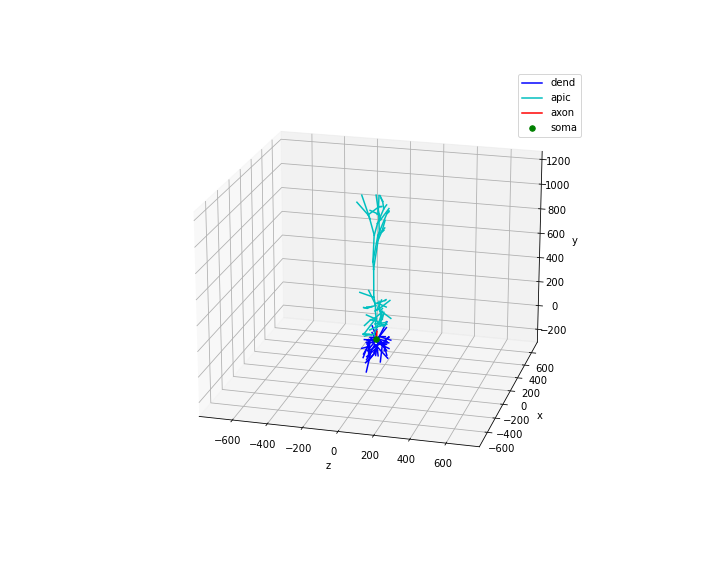

In [18]:
from utils.plotting.plot_morphology import plot_morphology
%matplotlib notebook

_ = plot_morphology(seg_coords=seg_coords, sec_nseg=nseg, type_id=seg_prop['swc_type'], elev=20, azim=-75, figsize=(10,8))

# Convert and save results

In [7]:
model_name = 'L5_model'

In [8]:
morph_file_name = 'lfp_result/' + model_name + '_SegProp.h5'
with h5py.File(morph_file_name, 'w') as hf:
        grp = hf.create_group('seg_prop')
        for key, value in seg_prop.items():
            grp.create_dataset(key, data=value)

In [9]:
im_file_name = 'lfp_result/' + model_name + '_Im.h5'
with h5py.File(im_file_name, 'w') as hf:
    hf.attrs['dt'] = dt
    hf.create_dataset('data', data=im)
    grp = hf.create_group('seg_coords')
    for key, value in seg_coords.items():
        grp.create_dataset(key, data=value)

# Plot variable with morphology

In [10]:
# im_den = im / np.expand_dims(seg_prop['seg_area'], 1) # nA/um^2
im_den = im / np.diff(seg_prop['distance'], axis=1) # nA/um

select_seg = None #seg_coords['pc'][:,0] > -50
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

var = im_den
varname = 'Transmembrane current density per unit length (nA/um)'
axes = ['x', 'y']
n_dist = 10
max_per_dist = 2
space = 0.01
normalized_space = False
sort_by_dist = True
figsize = (12,9)
fontsize = 15
scalebar_size = 50

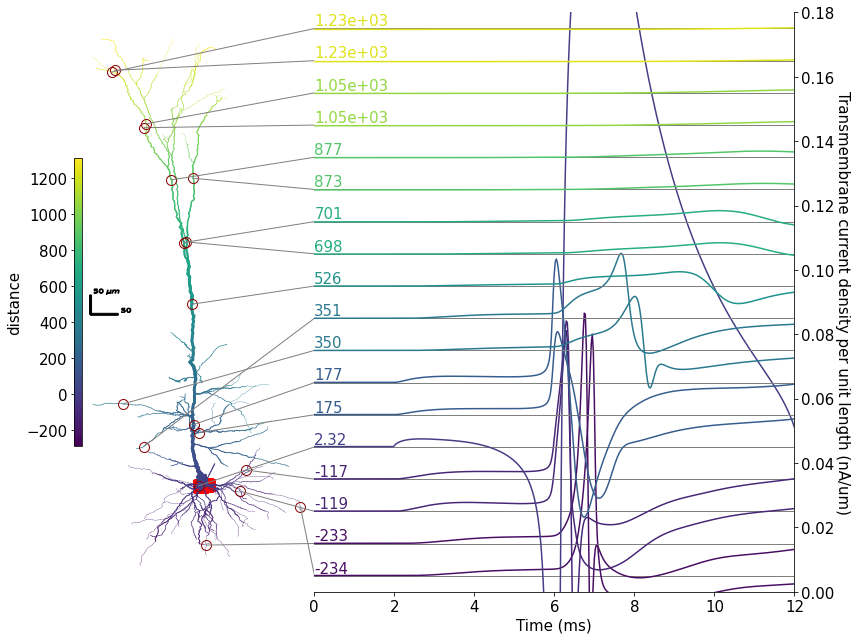

In [11]:
from utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
%matplotlib inline

_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t, axes=axes,
                                  distance_type='distance', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

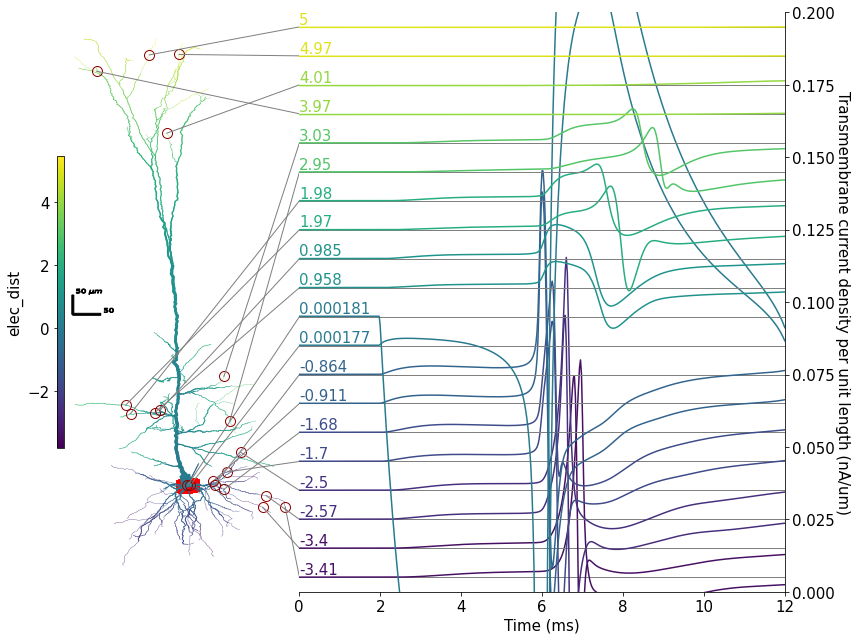

In [12]:
_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t, axes=axes,
                                  distance_type='elec_dist', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

Soma radius: 7.030115192693293 um


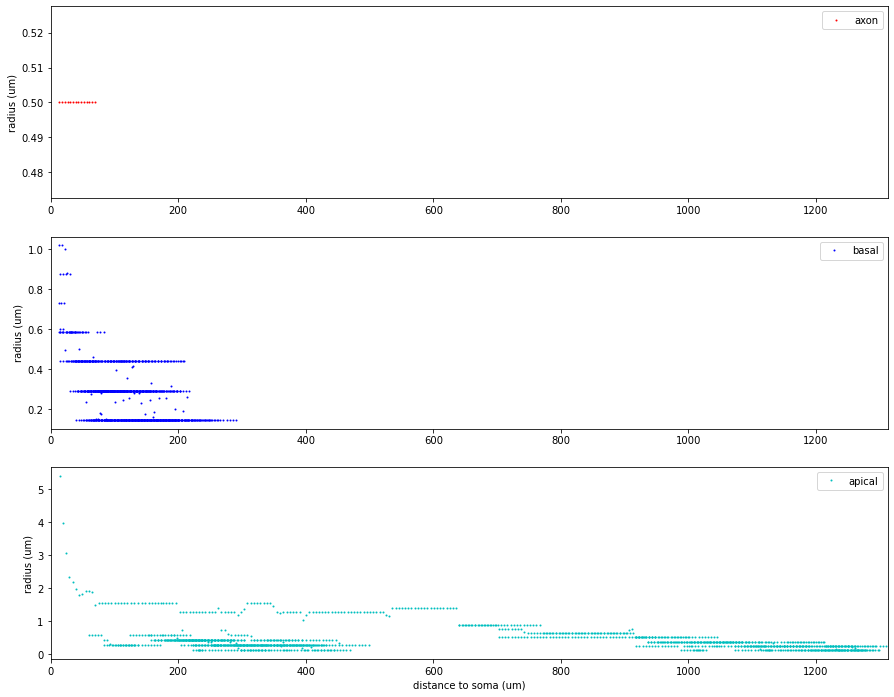

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot radius distribution
print('Soma radius: {} um'.format(seg_coords['r'][seg_prop['swc_type']==1][0]))

dist05 = np.abs(np.mean(seg_prop['distance'], axis=1))
colors = ['r', 'b', 'c']
names = ['axon', 'basal', 'apical']
plt.figure(figsize=(15,12))
for i in range(3):
    plt.subplot(3,1,i+1)
    idx = seg_prop['swc_type'] == i + 2
    plt.plot(dist05[idx], seg_coords['r'][idx], '.', color=colors[i], label=names[i], markersize=2)
    plt.legend(loc=1)
    plt.ylabel('radius (um)')
    plt.xlim([0, np.amax(seg_prop['distance'])])
plt.xlabel('distance to soma (um)')
plt.show()

# Plot LFP

In [14]:
from utils.currents.ecp import *
from utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from utils.spike_window import get_spike_window
from scipy import signal

with h5py.File('Electrode2D.h5', "r") as f:
    elec_file = 'sim_details/linear_electrode.csv'  # It isn't linear but in order to not change configs I kept the name
    elec_pos = np.hstack((f['coord'][:], np.zeros((384,1))))

ecp = EcpMod(EcpCell(file=im_file_name), elec_pos, min_distance=50.0)

In [15]:
loc_param = [0., 0., 80., 0., 1., 8*np.pi/8]

lfp = ecp.calc_ecp(move_cell=loc_param).T

In [16]:
WINDOW_SIZE = 176
pk_tr_idx_in_window = 24
filt_b,filt_a = signal.butter(2,100,'hp',fs=1000/dt)
lfp_filt = signal.lfilter(filt_b, filt_a, lfp, axis=0)
start, end = get_spike_window(lfp_filt, win_size=176, align_at=pk_tr_idx_in_window)
windowed_lfp = lfp_filt[start:end, :]
t = t[:WINDOW_SIZE]

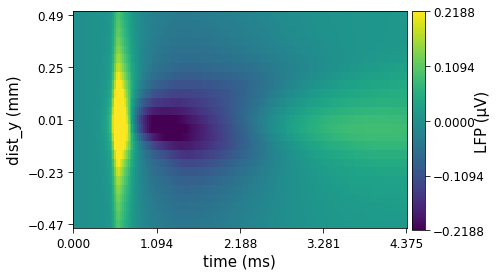

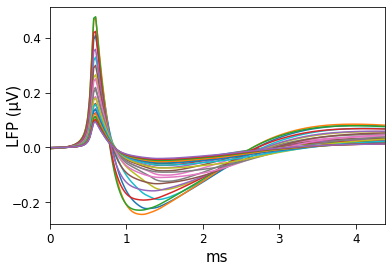

In [17]:
ix = 1
fontsize = 15
labelpad = -10
ticksize = 12
tick_length = 5
nbins = 5

ylim = [-500,500]
x_dist = np.unique(elec_pos[:, 0])
e_idx = (elec_pos[:,0]==x_dist[ix]) & (elec_pos[:,1]>=ylim[0]) & (elec_pos[:,1]<=ylim[1])

_ = plot_lfp_heatmap(t=t, elec_d=elec_pos[e_idx, 1], lfp=windowed_lfp[:, e_idx],
                     fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                     nbins=nbins, vlim='auto')

_ = plot_lfp_traces(t, windowed_lfp[:, e_idx],
                    fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
                    nbins=nbins)